## SETUP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
from keras import utils, models, layers, activations, optimizers, losses, callbacks
from scipy.io import wavfile
from IPython.display import clear_output
from collections import Counter, defaultdict
from sklearn.manifold import TSNE
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import librosa
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import keras
import shutil
import time
import random
import csv

## UNZIP

In [3]:
!unzip -qqq /content/drive/MyDrive/Research/brain-tumor-mri-dataset.zip -d /content/dataset/

## HYPER PARAMS

In [4]:
class HP:
    seed = 43
    batch_size = 32
    image_shape = (256, 256, 3)
    patch_size = (8, 8)
    num_classes = 4

## PREPARE THE DATASET

In [5]:
class_names = sorted(os.listdir("/content/dataset/Training"))
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [6]:
train_dataset, valid_dataset = keras.utils.image_dataset_from_directory(
    directory="/content/dataset/Training/",
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    batch_size=HP.batch_size,
    image_size=HP.image_shape[:-1],
    shuffle=True,
    seed=HP.seed,
    validation_split=0.1,
    subset="both",
)

test_dataset = keras.utils.image_dataset_from_directory(
    directory="/content/dataset/Testing/",
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    batch_size=HP.batch_size,
    image_size=HP.image_shape[:-1],
    shuffle=False,
    seed=HP.seed,
)

Found 5712 files belonging to 4 classes.
Using 5141 files for training.
Using 571 files for validation.
Found 1311 files belonging to 4 classes.


In [7]:
train_ds = train_dataset.cache(filename="train_dataset")
valid_ds= valid_dataset.cache(filename="valid_dataset")
test_ds = test_dataset.cache(filename="test_dataset")

## UTILS

In [8]:
@keras.saving.register_keras_serializable()
class STFTSpectrogram(layers.Layer):
    def __init__(self, frame_length=512, sequence_length=128, fft_length=512, **kwargs):
        super().__init__(**kwargs)
        self.frame_length = frame_length
        self.sequence_length = sequence_length
        self.fft_length = fft_length

    def call(self, inputs):
        stft_output = tf.signal.stft(
            signals=inputs,
            frame_length=self.frame_length,
            frame_step=self.sequence_length,
            fft_length=self.fft_length,
            pad_end=True,
        )
        magnitude_spectrogram = tf.abs(stft_output)
        log_spectrogram = tf.math.log1p(magnitude_spectrogram)
        return log_spectrogram[..., None]

    def get_config(self):
        config = super().get_config()
        config.update({
            "frame_length": self.frame_length,
            "sequence_length": self.sequence_length,
            "fft_length": self.fft_length
        })
        return config

In [9]:
@keras.saving.register_keras_serializable()
class Patches(keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, x):
        patches = keras.ops.image.extract_patches(x, self.patch_size, padding="same")
        batch_size = keras.ops.shape(patches)[0]
        n_patches = tf.shape(patches)[1] * tf.shape(patches)[2]
        patch_dim = tf.shape(patches)[3]
        output = keras.ops.reshape(patches, (batch_size, n_patches, patch_dim))
        return output

    def config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

In [10]:
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy from the training history.

    Parameters:
    - history: The history object returned by model.fit, containing the training and validation metrics.
    """
    # Extract data from history
    training_loss = history.history.get('loss', [])
    validation_loss = history.history.get('val_loss', [])
    training_accuracy = history.history.get('accuracy', [])
    validation_accuracy = history.history.get('val_accuracy', [])

    epochs = range(1, len(training_loss) + 1)

    # Set the plot style
    plt.style.use('seaborn-v0_8-whitegrid')  # Use 'ggplot' for better compatibility

    # Create the figure
    plt.figure(figsize=(20, 5))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, 'o-', label='Training Loss', color='blue')
    plt.plot(epochs, validation_loss, 'o-', label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Number of Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.xticks(epochs)  # Ensure epochs are displayed as integers
    plt.legend(fontsize=10)

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracy, 'o-', label='Training Accuracy', color='blue')
    plt.plot(epochs, validation_accuracy, 'o-', label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Number of Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(epochs)  # Ensure epochs are displayed as integers
    plt.legend(fontsize=10)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

In [11]:
def save_history_to_txt(history, filename="training_history.txt"):
    num_epochs = len(history.history['accuracy'])

    headers = ["Epoch", "Train_Accuracy", "Train_Loss", "Val_Accuracy", "Val_Loss", "Learning_Rate"]

    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        for epoch in range(num_epochs):
            writer.writerow([
                epoch + 1,
                history.history["accuracy"][epoch],
                history.history["loss"][epoch],
                history.history["val_accuracy"][epoch],
                history.history["val_loss"][epoch],
                # history.history["learning_rate"][epoch]
            ])

    print(f"Training history saved to {filename}")

## CONV BLOCKS

In [12]:
# @title ConvStem
@keras.saving.register_keras_serializable()
class ConvStem(layers.Layer):
    def __init__(self, filters, patch_size, extra_args={}, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.patch_size = patch_size
        self.extra_args = extra_args

    def build(self, input_shape):
        self.conv_layer = layers.Conv2D(
            filters=self.filters,
            kernel_size=self.patch_size,
            strides=self.patch_size,
            padding="valid",
            **self.extra_args
        )
        self.activation_layer = layers.LeakyReLU(negative_slope=0.25)
        self.batch_norm_layer = layers.BatchNormalization()
        super().build(input_shape)

    def call(self, inputs):
        x = self.conv_layer(inputs)
        x = self.activation_layer(x)
        x = self.batch_norm_layer(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "patch_size": self.patch_size,
            "extra_args": self.extra_args
        })
        return config

In [13]:
# @title StConvFeature
@keras.saving.register_keras_serializable()
class SpatiotemporalConvFeature(layers.Layer):
    def __init__(self, num_st, filters, head_size, kernel_size: tuple, extra_args={}, **kwargs):
        super().__init__(**kwargs)
        self.num_st = num_st
        self.filters = filters
        self.head_size = head_size
        self.kernel_size = kernel_size
        self.extra_args = extra_args

    def build(self, input_shape):
        self.conv_2d_layers = [
            layers.Conv2D(
                filters=self.head_size,
                kernel_size=self.kernel_size,
                strides=1,
                padding="same",
                **self.extra_args
            )
            for _ in range(self.num_st)
        ]

        self.activation_layers = [
            layers.LeakyReLU(negative_slope=0.25)
            for _ in range(self.num_st)
        ]

        self.batch_norm_layers = [
            layers.BatchNormalization()
            for _ in range(self.num_st)
        ]

        self.conv_3d_layer = layers.Conv3D(
            filters=self.filters,
            kernel_size=(self.num_st, self.kernel_size[0], self.kernel_size[1]),
            strides=1,
            padding="valid",
            kernel_initializer="random_normal",
            bias_initializer="zeros"
        )

        self.last_leaky_relu = layers.LeakyReLU(negative_slope=0.25)
        self.last_batch_norm = layers.BatchNormalization()
        super().build(input_shape)

    def call(self, x):
        self.u = []
        for i in range(self.num_st):
            x = self.conv_2d_layers[i](x)
            x = self.activation_layers[i](x)
            x = self.batch_norm_layers[i](x)
            self.u.append(x)
        x = tf.stack(self.u, axis=1)

        paddings = [
            [0, 0], [0, 0],
            [self.kernel_size[0] // 2, self.kernel_size[0] // 2],
            [self.kernel_size[1] // 2, self.kernel_size[1] // 2],
            [0, 0]
        ]
        x = tf.pad(x, paddings, mode="CONSTANT")

        x = self.conv_3d_layer(x)
        x = self.last_leaky_relu(x)
        x = self.last_batch_norm(x)

        return tf.squeeze(x, axis=1)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_st": self.num_st,
            "filters": self.filters,
            "head_size": self.head_size,
            "kernel_size": self.kernel_size,
            "extra_args": self.extra_args
        })
        return config

In [14]:
# @title ResidualBlock
@keras.saving.register_keras_serializable()
class ResidualBlock(layers.Layer):
    def __init__(self, filters, kernel_size, down, extra_args={}, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.down = down
        self.extra_args = extra_args

    def build(self, input_shape):
        self.batch_norm_layer = layers.BatchNormalization()
        self.activation_layer = layers.LeakyReLU(negative_slope=0.25)
        self.conv_2d_layer = layers.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=1,
            padding="same",
            **self.extra_args
        )

        if self.filters != input_shape[-1]:
            self.shortcut_conv_2d = layers.Conv2D(
                filters=self.filters,
                kernel_size=(1, 1),
                strides=1,
                padding="same",
                **self.extra_args
            )
        else:
            self.shortcut_conv_2d = None

        if self.down:
            self.max_pooling_layer_01 = layers.MaxPooling2D(
                pool_size=self.kernel_size,
                strides=2,
                padding="same"
            )
            self.max_pooling_layer_02 = layers.MaxPooling2D(
                pool_size=self.kernel_size,
                strides=2,
                padding="same"
            )
        super().build(input_shape)

    def call(self, inputs):
        if self.shortcut_conv_2d is not None:
            shortcut = self.shortcut_conv_2d(inputs)
        else:
            shortcut = inputs

        x = self.conv_2d_layer(inputs)
        x = self.activation_layer(x)
        x = self.batch_norm_layer(x)

        if self.down:
            x = self.max_pooling_layer_01(x)
            shortcut = self.max_pooling_layer_02(shortcut)

        return x + shortcut

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "down": self.down,
            "extra_args": self.extra_args
        })
        return config

In [15]:
# @title StRBlock
@keras.saving.register_keras_serializable()
class StRBlock(layers.Layer):
    def __init__(self, num_st, filters, kernel_size, resample, factor=2, extra_args={}, **kwargs):
        super().__init__(**kwargs)
        self.num_st = num_st
        self.filters = filters
        self.kernel_size = kernel_size
        self.resample = resample
        self.factor = factor
        self.extra_args = extra_args

    def build(self, input_shape):
        self.batch_norm_layer = layers.BatchNormalization()
        self.activation_layer = layers.LeakyReLU(negative_slope=0.25)

        self.st_conv_2d = SpatiotemporalConvFeature(
            num_st=self.num_st,
            filters=self.filters,
            head_size=self.filters // self.num_st,
            kernel_size=self.kernel_size,
            extra_args=self.extra_args
        )

        if self.filters != input_shape[-1]:
            self.shortcut_conv_2d = layers.Conv2D(
                filters=self.filters,
                kernel_size=(1, 1),
                strides=1,
                padding="same",
                **self.extra_args
            )
        else:
            self.shortcut_conv_2d = None

        if self.resample == "down":
            self.max_pooling_layer_01 = layers.MaxPooling2D(
                pool_size=self.kernel_size,
                strides=self.factor,
                padding="same"
            )
            self.max_pooling_layer_02 = layers.MaxPooling2D(
                pool_size=self.kernel_size,
                strides=self.factor,
                padding="same"
            )
        elif self.resample == "up":
            self.upsampling_layer_01 = layers.UpSampling2D(
                size=self.factor,
                interpolation="nearest"
            )
            self.upsampling_layer_02 = layers.UpSampling2D(
                size=self.factor,
                interpolation="nearest"
            )

    def call(self, inputs):
        if self.shortcut_conv_2d is not None:
            shortcut = self.shortcut_conv_2d(inputs)
        else:
            shortcut = inputs

        if self.resample == "down":
            shortcut = self.max_pooling_layer_02(shortcut)
            x = self.st_conv_2d(inputs)
            x = self.activation_layer(x)
            x = self.max_pooling_layer_01(x)
            return x + shortcut
        elif self.resample == "up":
            shortcut = self.upsampling_layer_02(shortcut)
            x = self.upsampling_layer_01(inputs)
            x = self.st_conv_2d(x)
            x = self.activation_layer(x)
            return x + shortcut
        else:
            x = self.st_conv_2d(inputs)
            x = self.activation_layer(x)
            return x + shortcut

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_st": self.num_st,
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "resample": self.resample,
            "factor": self.factor,
            "extra_args": self.extra_args
        })
        return config

## CREATE MODEL

In [16]:
def augmentation(x):
    x = layers.RandomFlip(mode="horizontal")(x)
    return x

In [17]:
def create_cnn_model(input_shape, output_dimension):
    inputs = layers.Input(shape=input_shape)
    x = augmentation(inputs)
    x = keras.applications.resnet_v2.preprocess_input(x)

    resnet50_v2 = keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet",
        input_tensor=x,
        input_shape=input_shape,
        pooling=None
    )
    resnet50_v2.trainable = False

    x = layers.GlobalAveragePooling2D()(resnet50_v2.output)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(256, activation="gelu")(x)

    outputs = layers.Dense(output_dimension, activation="softmax")(x)

    return models.Model(inputs=inputs, outputs=outputs)


model = create_cnn_model(
    input_shape=HP.image_shape,
    output_dimension=HP.num_classes
)

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=1e-4,
        beta_1=tf.sqrt(2.0 / np.pi),
        beta_2=0.999,
        epsilon=1e-6
    ),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 256, 256,  │          0 │ random_flip[0][0] │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 256, 256,  │          0 │ true_divide[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ subtract[0][0]    │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 64, 64,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 64, 64,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 66, 66,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b

 Total params: 24,090,372 (91.90 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

## TRAIN

In [ ]:
def lr_scheduler(epoch):
    if epoch + 1 <= 20:
        return 1e-4
    else:
        return 1e-5

lr_schedule = keras.callbacks.LearningRateScheduler(lr_scheduler)

def best_model_saver_function(filepath="best_model_01.keras"):
    return keras.callbacks.ModelCheckpoint(
        filepath=filepath,
        save_best_only=True,
        monitor="val_loss",
        mode="min",
        verbose=1
    )

best_model_saver = best_model_saver_function()

In [ ]:
start_time = time.time()
history = model.fit(
    train_ds,
    epochs=35,
    validation_data=valid_ds,
    callbacks=[lr_schedule, best_model_saver]
)
end_time = time.time()

print(f"Training time: {end_time - start_time} seconds")

Epoch 1/35
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.6209 - loss: 0.9421
Epoch 1: val_loss improved from inf to 0.36047, saving model to best_model_01.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 71s 277ms/step - accuracy: 0.6217 - loss: 0.9404 - val_accuracy: 0.8809 - val_loss: 0.3605 - learning_rate: 1.0000e-04
Epoch 2/35
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8659 - loss: 0.3741
Epoch 2: val_loss improved from 0.36047 to 0.29541, saving model to best_model_01.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 49s 167ms/step - accuracy: 0.8659 - loss: 0.3740 - val_accuracy: 0.8967 - val_loss: 0.2954 - learning_rate: 1.0000e-04
Epoch 3/35
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8859 - loss: 0.3060
Epoch 3: val_loss improved from 0.29541 to 0.27382, saving model to best_model_01.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.8859 - loss: 0.3059 - val_accuracy: 0.8984 - val_loss: 0.2738 - learning_rate: 1.0000e-04
Epoch 4/35
161/161 ━━━━━━━━━━━━━

In [ ]:
save_history_to_txt(history, filename="resnet50_v2_history.txt")

Training history saved to resnet50_v2_history.txt


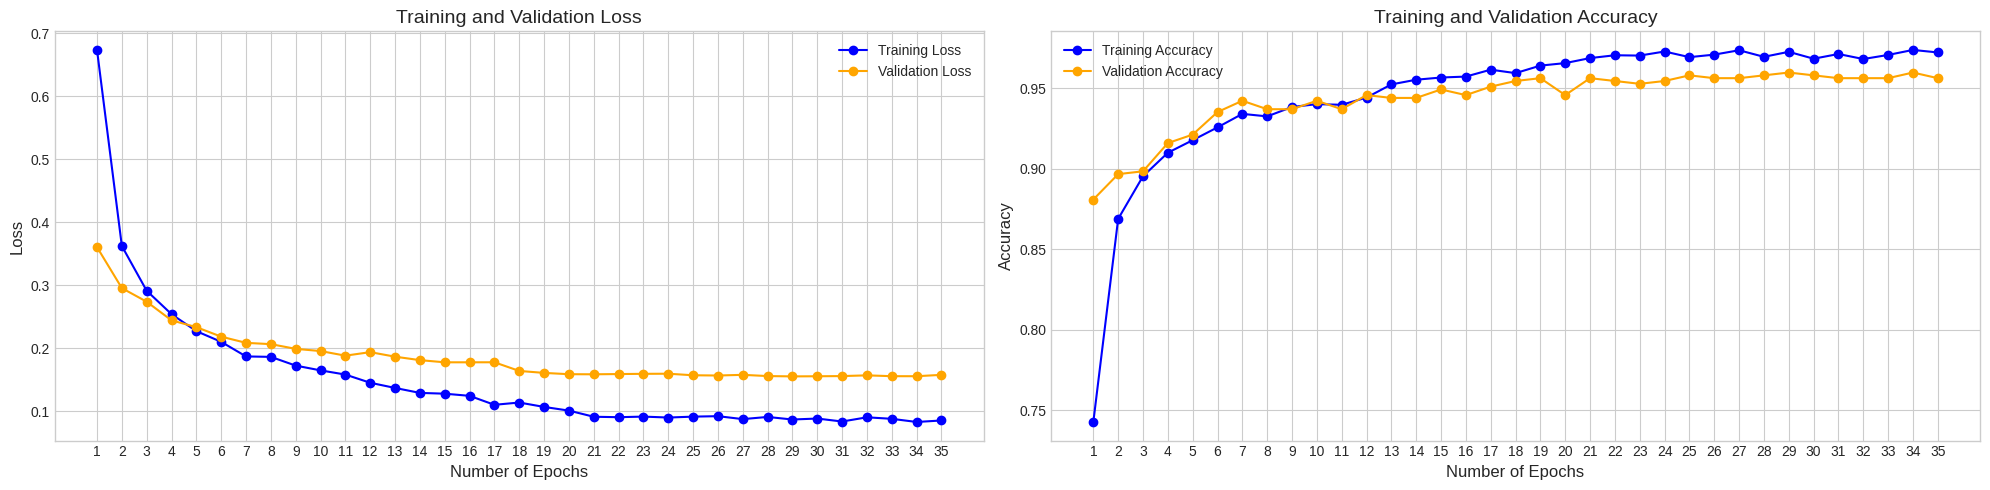

In [ ]:
plot_training_history(history)

## EVALUATE

In [ ]:
best_vl_model = keras.models.load_model("best_model_01.keras")
loss, accuracy = best_vl_model.evaluate(test_ds)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 370ms/step - accuracy: 0.9567 - loss: 0.1392
Test loss: 0.14285552501678467
Test accuracy: 0.9549961686134338


In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9617 - loss: 0.1318
Test loss: 0.13724298775196075
Test accuracy: 0.9557589888572693


In [ ]:
# model.save("/content/drive/MyDrive/Research/STCNN/final_resnet50_v2.keras")
# loaded_model = keras.models.load_model("/content/drive/MyDrive/Research/STCNN/final_resnet50_v2.keras")

## UNFREEZE

In [ ]:
loaded_model = keras.models.load_model("/content/drive/MyDrive/Research/STCNN/final_resnet50_v2.keras")

for layer in loaded_model.layers[-50:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

loaded_model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=1e-6,
        beta_1=tf.sqrt(2.0 / np.pi),
        beta_2=0.999,
        epsilon=1e-6
    ),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

start_time = time.time()
history = loaded_model.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds,
    callbacks=[best_model_saver]
)
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9738 - loss: 0.0834
Epoch 1: val_loss improved from inf to 0.14844, saving model to best_model_01.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 72s 308ms/step - accuracy: 0.9738 - loss: 0.0834 - val_accuracy: 0.9615 - val_loss: 0.1484
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9841 - loss: 0.0621
Epoch 2: val_loss improved from 0.14844 to 0.14352, saving model to best_model_01.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - accuracy: 0.9840 - loss: 0.0621 - val_accuracy: 0.9632 - val_loss: 0.1435
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9796 - loss: 0.0592
Epoch 3: val_loss improved from 0.14352 to 0.13776, saving model to best_model_01.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 26s 161ms/step - accuracy: 0.9797 - loss: 0.0592 - val_accuracy: 0.9667 - val_loss: 0.1378
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9853 - loss: 0.0502
Epoch 4: val_loss improved f

In [ ]:
save_history_to_txt(history, filename="unfreeze50_resnet50_v2_history.txt")

Training history saved to unfreeze50_resnet50_v2_history.txt


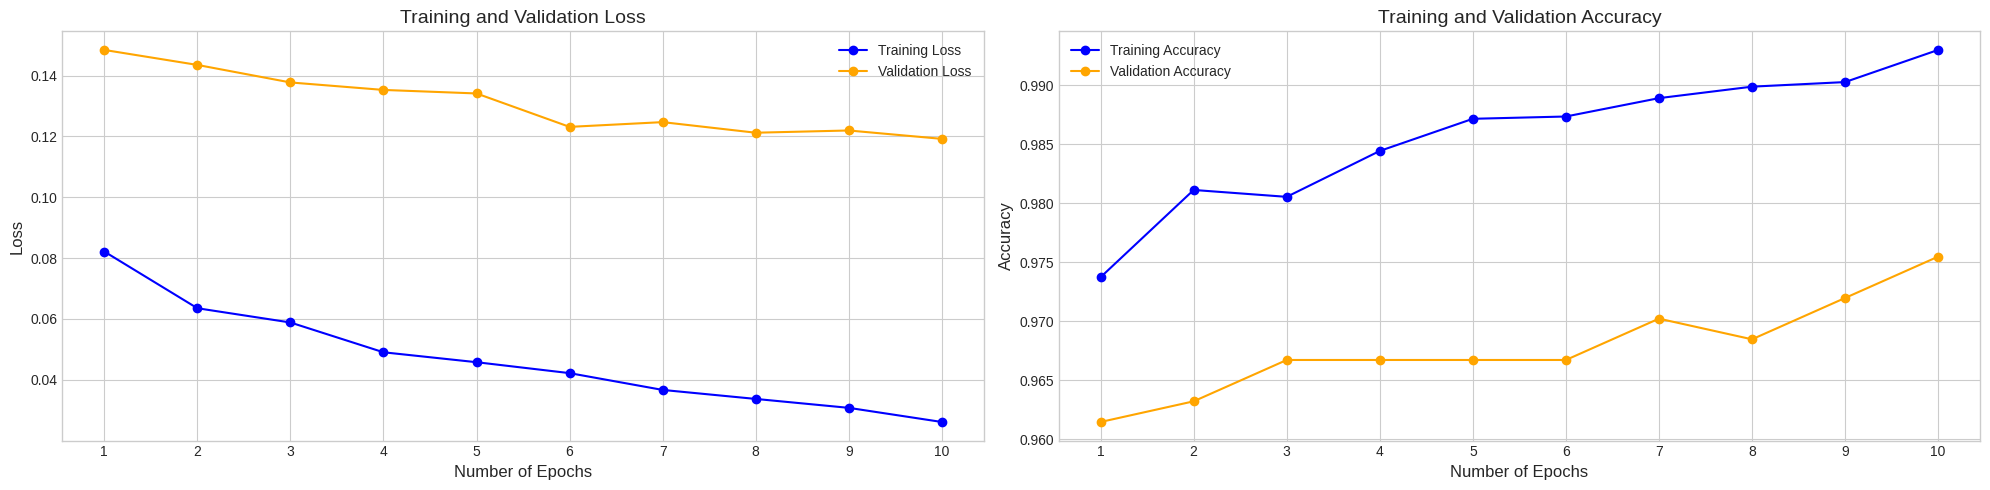

In [ ]:
plot_training_history(history)

In [ ]:
best_val_loss_model = keras.models.load_model("best_model_01.keras")
loss, accuracy = best_val_loss_model.evaluate(test_ds)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 263ms/step - accuracy: 0.9705 - loss: 0.0836
Test loss: 0.08812835812568665
Test accuracy: 0.970251739025116


In [ ]:
loss, accuracy = loaded_model.evaluate(test_ds)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9705 - loss: 0.0836
Test loss: 0.08812835812568665
Test accuracy: 0.970251739025116


In [ ]:
# best_val_loss_model.save("/content/drive/MyDrive/Research/STCNN/final_unfreeze50_resnet50_v2.keras")

## t-SNE

In [ ]:
loaded_model = keras.models.load_model("/content/drive/MyDrive/Research/STCNN/final_unfreeze50_resnet50_v2.keras")

In [ ]:
def tsne_function(model, dataset):
    embedding_model = keras.models.Model(
        inputs=model.input,
        outputs=loaded_model.get_layer(index=-2).output
    )
    embeddings = embedding_model.predict(dataset)
    labels = []
    for x_batch, y_batch in dataset:
        labels.append(y_batch.numpy())
    labels = np.concatenate(labels, axis=0)

    tsne = TSNE(n_components=2, random_state=HP.seed)
    tsne_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8), dpi=1200)
    num_classes = len(np.unique(labels))
    for i in range(num_classes):
        indices = labels == i
        plt.scatter(
            tsne_embeddings[indices, 0],
            tsne_embeddings[indices, 1],
            label=f'Class {i}',
            alpha=0.6,
            s=15
        )

    plt.legend()
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

In [ ]:
tsne_function(loaded_model, test_ds)

Output hidden; open in https://colab.research.google.com to view.

## FEATURE_MAPS

In [16]:
loaded_model = keras.models.load_model("/content/drive/MyDrive/Research/STCNN/final_unfreeze50_resnet50_v2.keras")

In [18]:
def visualize_feature_maps(target_layer_type, model, image_path, num_filters=16, target_size=(256, 256)):
    last_target_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, target_layer_type):
            last_target_layer = layer
            break

    if last_target_layer is None:
        raise ValueError(f"No layer of type {target_layer_type} found in the model.")

    feature_model = keras.models.Model(
        inputs=model.input,
        outputs=last_target_layer.output
    )
    image = plt.imread(image_path)
    image = tf.image.resize(image, (256, 256))
    image = np.expand_dims(image, axis=0)

    fig, axes = plt.subplots(4, 4, figsize=(10, 10), dpi=1200)  # 4x4
    axes = axes.ravel()

    feature_maps = feature_model(image)
    num_filters = min(num_filters, feature_maps.shape[-1])

    for i in range(num_filters):
        feature_map = feature_maps[0, :, :, i]
        axes[i].imshow(feature_map, cmap='viridis')
        axes[i].axis('off')
        axes[i].set_title(f'Filter {i+1}')

    plt.suptitle(f"Feature Maps")
    plt.show()


target_layer_type = layers.Conv2D
visualize_feature_maps(target_layer_type, loaded_model, image_path="/content/dataset/Testing/glioma/Te-glTr_0000.jpg")

## METRICS

In [18]:
loaded_model = keras.models.load_model("/content/drive/MyDrive/Research/STCNN/final_unfreeze50_resnet50_v2.keras")

In [19]:
y_true = []
for x_batch, y_batch in test_dataset:
    y_true.append(y_batch.numpy())

y_true = np.concatenate(y_true, axis=0)

y_pred = loaded_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=-1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 461ms/step


In [22]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.99      0.92      0.95       300
  meningioma       0.92      0.96      0.94       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311

